In [1]:
class Point:
    def __init__(self, x=0, y=0):
        self.x = x
        self.y = y
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    def __repr__(self) -> str:
        return f"({self.x},{self.y})"
    
    def __hash__(self):
        return hash((self.x, self.y))
    
    def distance_to_origin(self) -> float:
        return (self.x**2 + self.y**2)**0.5

    def distance_to(self, other) -> float:
        return ((self.x - other.x)**2 + (self.y - other.y)**2)**0.5



class Segment:
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2
        self.midpoint = Point((p1.x + p2.x)/2, (p1.y + p2.y)/2)
        
    def __repr__(self):
        return f"({self.p1}--{self.p2})"

    def __eq__ (self, other):
        return self.p1 == other.p1 and self.p2 == other.p2 or self.p1 == other.p2 and self.p2 == other.p1
    
    def isIntersecting(self, other):
        if self.p1 == other.p1 or self.p1 == other.p2 or self.p2 == other.p1 or self.p2 == other.p2:
            return False

        def ccw(A,B,C):
            return (C.y-A.y) * (B.x-A.x) > (B.y-A.y) * (C.x-A.x)
        
        A = self.p1
        B = self.p2
        C = other.p1
        D = other.p2
        return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)
        
        

class Arrow (Segment):
    # direction = 1 means p1 <- p2, -1 means p1 -> p2, 0 means p1 == p2
    def __init__(self, p1, p2, direction=0):
        super().__init__(p1, p2)
        self.direction = direction

    def __repr__(self):
        return (f"({self.p1} <- {self.p2})" if self.direction > 0 else 
            f"({self.p1} -> {self.p2})" if self.direction < 0 else 
            f"({self.p1} == {self.p2})")

    def __eq__(self, other: 'Arrow'):
        return ((self.p1 == other.p1 and self.p2 == other.p2 and self.direction*other.direction >= 0) or
                (self.p1 == other.p2 and self.p2 == other.p1 and self.direction*other.direction <= 0))

class Triangle:
    def __init__(self,p1:Point,p2:Point,p3:Point):
        self.p1 = p1
        self.p2 = p2
        self.p3 = p3
    def __repr__(self):
        return f"T({self.p1},{self.p2},{self.p3})"

    def perimeter(self):
        return self.p1.distance_to(self.p2) + self.p2.distance_to(self.p3) + self.p3.distance_to(self.p1)

    def area(self):
        return abs(self.p1.x * (self.p2.y - self.p3.y) + self.p2.x * (self.p3.y - self.p1.y) + self.p3.x * (self.p1.y - self.p2.y)) / 2



class Polygon:
    def __init__(self, *args):
        if len(args) < 3:
            raise ValueError("A polygon must have at least 3 points")
        self.points = args
        self.segments = []
        for i in range(len(self.points)-1):
            self.segments.append(Segment(self.points[i], self.points[i+1]))
        self.segments.append(Segment(self.points[-1], self.points[0]))

    def perimeter(self):
        perimeter = 0
        for i in range(len(self.points)):
            perimeter += self.points[i].distance_to(self.points[(i+1)%len(self.points)])
        return perimeter

    def __contains__(self, point:Point):
        for i in range(len(self.points)):
            if point.distance_to(Segment(self.points[i], self.points[(i+1)%len(self.points)])) == 0:
                return True
        return False

    def __repr__(self):
        return f"Polygon{self.points}"

In [2]:
# we suppose the points are given so no overlap happens between the segments they constitute

def getNeighbors(point: Point, listSegments: list[Segment]):
    neighbors = []
    for seg in listSegments:
        if point == seg.p1 and seg.p2 not in neighbors:
            neighbors.append(seg.p2)
        elif point == seg.p2 and seg.p1 not in neighbors:
            neighbors.append(seg.p1)
    return neighbors

def midpoint(p1: Point, p2: Point) -> Point:
        return Point((p1.x + p2.x) / 2, (p1.y + p2.y) / 2)

def raycasting(point: Point, vector: Point, polygon: Polygon) -> int:
    ray = Segment(point, Point(point.x + vector.x * 1e6, point.y + vector.y * 1e6))
    hits = 0
    for edge in polygon.segments:
        if ray.isIntersecting(edge):
            hits += 1
    return hits

def isSegmentInsidePolygon(segment:Segment, polygon: Polygon) -> bool:
    midpoint = segment.midpoint
    normal= Point(-(segment.p2.y - segment.p1.y), segment.p2.x - segment.p1.x)
    casts = raycasting(midpoint,normal,polygon)
    return casts%2 == 1

def isSegmentValid(currSeg: Segment, polygon: Polygon, listSegments: list[Segment]) -> bool:
    if not isSegmentInsidePolygon(currSeg, polygon):
        return False
    if any(currSeg.isIntersecting(seg) for seg in listSegments):
        return False
    return True

def getOrderedAccessibleClosestPoints(start: Point, polygon:Polygon, listSegments: list[Segment]) -> list[Point]:
    listDistance = []
    neighbors = getNeighbors(start, listSegments)
    for pt in polygon.points:
        if pt != start and pt not in neighbors:
            currSeg = Segment(start,pt)
            if isSegmentValid(currSeg, polygon, listSegments):
                listDistance.append((pt,start.distance_to(pt)))
    return [pt for pt,_ in sorted(listDistance,key=lambda x:x[1])]

#turn the polygon into a graph and do a BFS to get the triangles
def orientSegments(point:Point, listPoint: list[Point], listAllSegments: list[Segment]) -> list[Arrow]:
    arrows = []
    visited = {pt:False for pt in listPoint}
    visited[point] = True
    currentPoints = [point]
    nextPoints = []
    while currentPoints:
        for pt in currentPoints:
            neighbors = getNeighbors(pt, listAllSegments)
            for neighbor in neighbors:
                if not visited[neighbor]:
                    nextPoints.append(neighbor)
                    arrows.append(Arrow(pt, neighbor, 1))
        for pt in nextPoints:
            visited[pt] = True
        currentPoints = nextPoints
        nextPoints = []
    return arrows

def getSummitsForTriangular(end: Point, start:Point, arrows: list[Arrow]) -> list[Point]:
    outgoingSummitsFromStart = []
    for arrow in arrows:
        if (arrow.p1 == start and arrow.direction < 0):
            outgoingSummitsFromStart.append(arrow.p2) 
        if (arrow.p2 == start and arrow.direction > 0):
            outgoingSummitsFromStart.append(arrow.p1)
    print(f"outgoingSummitsFromStart: {outgoingSummitsFromStart}")
    ingoingSummitsToEnd = []
    for summit in outgoingSummitsFromStart:
        arrow = Arrow(end,summit,0)
        for a in arrows:
            if a == arrow:
                ingoingSummitsToEnd.append(summit)
    return ingoingSummitsToEnd

def refreshAccessibleClosestPoints(anchor:Point, visiblePointCache:dict[Point:list[Point]],allSegments:list[Segment]) -> None:
    visibleNeighbors = visiblePointCache[anchor]
    visibleNeighbors[anchor] = [neighbor for neighbor in visibleNeighbors if not any(Segment(anchor, neighbor).isIntersecting(seg) for seg in allSegments)]

def triangulatePolygon(polygon:Polygon) -> list[Triangle]:
    #Init: 
    # 1. list of triangles
    # 2. list of all segments
    # 3. cache of visible points for each point
    # 4. getting a starting point with at least one visible point
    triangles = []
    visiblePointsCache = {}
    listAllSegments = polygon.segments.copy()
    visiblePoints = getOrderedAccessibleClosestPoints(polygon.points[0], polygon, listAllSegments)
    i = 0
    while not visiblePoints and i < len(polygon.points):
        visiblePoints = getOrderedAccessibleClosestPoints(polygon.points[i], polygon, listAllSegments)
        i+=1
    if not visiblePoints:
        return []
    parkouredPointsStack = [polygon.points[i]]
    #Loop:
    # 1. get the next the closest accessible point
    # If there is no accessible point, we backtrack to the last crossed point
    # 2. get the arrows from the current point
    # 3. get the potential summits to make triangles with the current point and the closest point
    # 4. add the triangles to the list
    # 5. add the closest point to the stack and loop
    while parkouredPointsStack:
        print(f"Current point:{parkouredPointsStack[-1]}, current triangles: {triangles}")
        currentPoint = parkouredPointsStack[-1]

        if currentPoint in visiblePointsCache:
            closestPoints = visiblePointsCache[currentPoint]
            refreshAccessibleClosestPoints(currentPoint, visiblePointsCache, listAllSegments)
        else:
            closestPoints = getOrderedAccessibleClosestPoints(currentPoint, polygon, listAllSegments)
        print(f"Closest points: {closestPoints}")
        if not closestPoints:
            parkouredPointsStack.pop()
            continue
        closestPoint = closestPoints[0]
        currentArrows = orientSegments(currentPoint, polygon.points, listAllSegments)
        print(f"Current arrows: {currentArrows}")
        summits = getSummitsForTriangular(currentPoint, closestPoint, currentArrows)
        print(f"Found summits for triangles: {summits}")
        for summit in summits:
            triangles.append(Triangle(currentPoint,closestPoint,summit))
        print("-------------------------")
        listAllSegments.append(Segment(currentPoint,closestPoint))
        parkouredPointsStack.append(closestPoint)
    return triangles

In [5]:
import matplotlib.pyplot as plt

def display_polygon(polygon):
    _, ax = plt.subplots()
    x = [point.x for point in polygon.points] + [polygon.points[0].x]
    y = [point.y for point in polygon.points] + [polygon.points[0].y]
    ax.plot(x, y, marker='o')
    ax.set_aspect('equal', 'box')
    plt.title('Polygon')
    plt.show()

def display_triangles(triangles):
    _,ax = plt.subplots()
    for triangle in triangles:
        x = [triangle.p1.x, triangle.p2.x, triangle.p3.x, triangle.p1.x]
        y = [triangle.p1.y, triangle.p2.y, triangle.p3.y, triangle.p1.y]
        ax.plot(x, y, marker='o')
    ax.set_aspect('equal', 'box')
    plt.title('Triangles')
    plt.show()

In [47]:
import random
import math

def generate_random_simple_polygon(n: int, radius=10):
    if n < 3:
        raise ValueError("A polygon must have at least 3 vertices")
    
    # Step 1: Generate points on a circle
    points = []
    angle_step = 2 * math.pi / n  # Step size to place n points evenly on a circle
    for i in range(n):
        angle = i * angle_step + random.uniform(-0.1, 0.1)  # Adding randomness to angles
        x = radius * math.cos(angle) + random.uniform(-1, 1)  # Small noise to make it more irregular
        y = radius * math.sin(angle) + random.uniform(-1, 1)
        points.append(Point(x, y))
    
    # Step 2: Sort points by their angle from the centroid (convex polygon)
    centroid = Point(sum(p.x for p in points) / n, sum(p.y for p in points) / n)
    
    def angle_from_centroid(point):
        return math.atan2(point.y - centroid.y, point.x - centroid.x)
    
    points.sort(key=angle_from_centroid)

    # Step 3: Create the polygon
    return Polygon(*points)


Current point:(0,0), current triangles: []
Closest points: [(3,4), (5,3), (6,1), (18,2), (19,0)]
Current arrows: [((0,0) <- (1,3)), ((0,0) <- (2,0)), ((1,3) <- (3,4)), ((2,0) <- (3,-2)), ((3,4) <- (5,3)), ((3,-2) <- (5,-3)), ((5,3) <- (6,1)), ((5,-3) <- (7,-1)), ((6,1) <- (7,4)), ((7,-1) <- (9,-2)), ((7,4) <- (9,5)), ((9,-2) <- (11,-3)), ((9,5) <- (11,4)), ((11,-3) <- (13,-2)), ((11,4) <- (12,2)), ((13,-2) <- (15,-3)), ((12,2) <- (14,3)), ((15,-3) <- (17,-2)), ((14,3) <- (15,5)), ((17,-2) <- (19,0)), ((15,5) <- (17,4)), ((19,0) <- (18,2))]
outgoingSummitsFromStart: [(1,3)]
Found summits for triangles: [(1,3)]
-------------------------
Current point:(3,4), current triangles: [T((0,0),(3,4),(1,3))]
Closest points: [(2,0), (6,1), (3,-2), (7,-1), (5,-3)]
Current arrows: [((3,4) <- (1,3)), ((3,4) <- (5,3)), ((3,4) <- (0,0)), ((5,3) <- (6,1)), ((0,0) <- (2,0)), ((6,1) <- (7,4)), ((2,0) <- (3,-2)), ((7,4) <- (9,5)), ((3,-2) <- (5,-3)), ((9,5) <- (11,4)), ((5,-3) <- (7,-1)), ((11,4) <- (12,2))

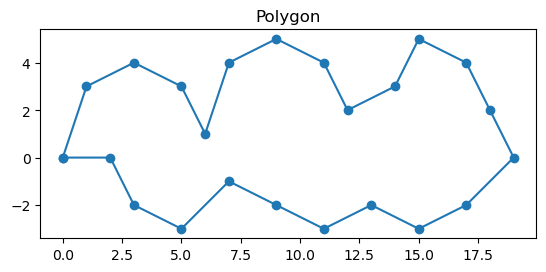

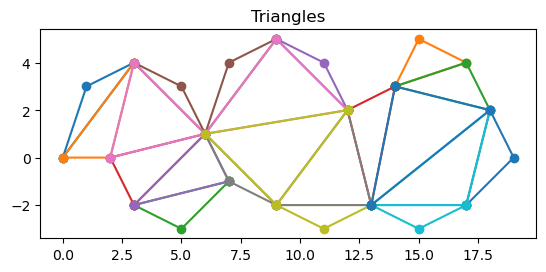

In [4]:
import math

# polygon = Polygon(Point(0,0), Point(2,5), Point(3,3), Point(4,5),Point(6,0), Point(3,-2))
polygon = Polygon(
    Point(0, 0), Point(1, 3), Point(3, 4), Point(5, 3), Point(6, 1), Point(7, 4), Point(9, 5), Point(11, 4), 
    Point(12, 2), Point(14, 3), Point(15, 5), Point(17, 4), Point(18, 2), Point(19, 0), Point(17, -2), 
    Point(15, -3), Point(13, -2), Point(11, -3), Point(9, -2), Point(7, -1), Point(5, -3), Point(3, -2), Point(2, 0)
)
# polygon = Polygon(Point(0.5,0), Point(1.5,0), Point(2.5,-.5), Point(2,-1.5), Point(0.5,-2), Point(0,-1))

# dodecahedron_vertices = []
# for k in range(12):
#     angle = 2 * math.pi * k / 12    
#     x = math.cos(angle)
#     y = math.sin(angle)
#     dodecahedron_vertices.append(Point(x, y))

# polygon = Polygon(*dodecahedron_vertices)

# polygon = generate_random_simple_polygon(100)
triangles = triangulatePolygon(polygon)
display_polygon(polygon)
display_triangles(triangles)

In [28]:
import imageio
import os

import matplotlib.pyplot as plt

def triangulatePolygonVisual(polygon: Polygon) -> list[Triangle]:
    def save_frame(current_segment=None):
        _, ax = plt.subplots()
        x = [point.x for point in polygon.points] + [polygon.points[0].x]
        y = [point.y for point in polygon.points] + [polygon.points[0].y]
        ax.plot(x, y, marker='o', color='black')
        for segment in listAllSegments:
            if segment not in polygon.segments:
                ax.plot([segment.p1.x, segment.p2.x], [segment.p1.y, segment.p2.y], 'b', linewidth=0.5)
        for triangle in triangles:
            tx = [triangle.p1.x, triangle.p2.x, triangle.p3.x, triangle.p1.x]
            ty = [triangle.p1.y, triangle.p2.y, triangle.p3.y, triangle.p1.y]
            ax.fill(tx, ty, 'green', edgecolor='green', alpha=0.5)
        if current_segment:
            ax.plot([current_segment.p1.x, current_segment.p2.x], [current_segment.p1.y, current_segment.p2.y], 'r', linewidth=.75)
        
        ax.set_aspect('equal', 'box')
        plt.title('Triangulation Step')
        plt.savefig('frame.png')
        plt.close()
        frames.append(imageio.imread('frame.png'))
        os.remove('frame.png')
    
    # Init: 
    # 1. list of triangles
    # 2. list of all segments
    # 3. cache of visible points for each point
    # 4. getting a starting point with at least one visible point
    triangles = []
    visiblePointsCache = {}
    listAllSegments = polygon.segments.copy()
    visiblePoints = getOrderedAccessibleClosestPoints(polygon.points[0], polygon, listAllSegments)
    i = 0
    while not visiblePoints and i < len(polygon.points):
        visiblePoints = getOrderedAccessibleClosestPoints(polygon.points[i], polygon, listAllSegments)
        i += 1
    if not visiblePoints:
        return []

    parkouredPointsStack = [polygon.points[i]]
    frames = []
    # Loop:
    # 1. get the next the closest accessible point
    # If there is no accessible point, we backtrack to the last crossed point
    # 2. get the arrows from the current point
    # 3. get the potential summits to make triangles with the current point and the closest point
    # 4. add the triangles to the list
    # 5. add the closest point to the stack and loop
    while parkouredPointsStack:
        currentPoint = parkouredPointsStack[-1]

        if currentPoint in visiblePointsCache:
            closestPoints = visiblePointsCache[currentPoint]
            refreshAccessibleClosestPoints(currentPoint, visiblePointsCache, listAllSegments)
        else:
            closestPoints = getOrderedAccessibleClosestPoints(currentPoint, polygon, listAllSegments)

        if not closestPoints:
            parkouredPointsStack.pop()
            continue

        closestPoint = closestPoints[0]
        currentArrows = orientSegments(currentPoint, polygon.points, listAllSegments)
        summits = getSummitsForTriangular(currentPoint, closestPoint, currentArrows)

        for summit in summits:
            triangles.append(Triangle(currentPoint, closestPoint, summit))

        current_segment = Segment(currentPoint, closestPoint)
        listAllSegments.append(current_segment)
        parkouredPointsStack.append(closestPoint)
        save_frame(current_segment)

    imageio.mimsave('triangulation.gif', frames, fps=.75)

    return triangles

In [29]:
triangulatePolygonVisual(polygon)

outgoingSummitsFromStart: [(1,3)]
outgoingSummitsFromStart: [(0,0)]
outgoingSummitsFromStart: [(5,3)]


C:\Users\Tech\AppData\Local\Temp\ipykernel_22656\2421988946.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread('frame.png'))


outgoingSummitsFromStart: [(5,-3)]
outgoingSummitsFromStart: [(5,-3)]
outgoingSummitsFromStart: [(2,0), (7,-1)]
outgoingSummitsFromStart: [(5,3), (2,0)]
outgoingSummitsFromStart: [(7,-1)]
outgoingSummitsFromStart: [(11,-3)]
outgoingSummitsFromStart: [(15,-3)]
outgoingSummitsFromStart: [(19,0)]
outgoingSummitsFromStart: [(15,5)]
outgoingSummitsFromStart: [(15,5), (18,2)]
outgoingSummitsFromStart: [(17,-2)]
outgoingSummitsFromStart: [(14,3)]
outgoingSummitsFromStart: [(11,4)]
outgoingSummitsFromStart: [(7,4)]
outgoingSummitsFromStart: [(9,5)]
outgoingSummitsFromStart: [(13,-2), (6,1)]
outgoingSummitsFromStart: [(17,-2), (14,3)]


[T((0,0),(3,4),(1,3)),
 T((3,4),(2,0),(0,0)),
 T((7,-1),(3,-2),(5,-3)),
 T((3,-2),(6,1),(2,0)),
 T((3,-2),(6,1),(7,-1)),
 T((6,1),(3,4),(5,3)),
 T((6,1),(3,4),(2,0)),
 T((6,1),(9,-2),(7,-1)),
 T((9,-2),(13,-2),(11,-3)),
 T((13,-2),(17,-2),(15,-3)),
 T((17,-2),(18,2),(19,0)),
 T((14,3),(17,4),(15,5)),
 T((14,3),(17,4),(18,2)),
 T((13,-2),(12,2),(14,3)),
 T((12,2),(9,5),(11,4)),
 T((9,5),(6,1),(7,4)),
 T((6,1),(12,2),(9,5)),
 T((12,2),(9,-2),(13,-2)),
 T((12,2),(9,-2),(6,1)),
 T((13,-2),(18,2),(17,-2)),
 T((13,-2),(18,2),(14,3))]

In [8]:
print(sum(triangle.area() for triangle in triangles))

3.0
